Tests for decision neurons, which we define as neurons where $\Delta F/F$ before the perturbation encodes behavior after, for a particular behavior vs. all other behaviors. When testing, we include dependence in our model on specifici behaviors before the manipulation, to control for correlation between before and after behaviors.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

from keller_zlatic_vnc.data_processing import count_unique_subjs_per_transition
from keller_zlatic_vnc.data_processing import extract_transitions
from keller_zlatic_vnc.data_processing import generate_transition_dff_table
from keller_zlatic_vnc.data_processing import read_raw_transitions_from_excel
from keller_zlatic_vnc.data_processing import recode_beh
from keller_zlatic_vnc.linear_modeling import one_hot_from_table
from keller_zlatic_vnc.linear_modeling import order_and_color_interaction_terms
from keller_zlatic_vnc.linear_modeling import reference_one_hot_to_beh


from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats
from janelia_core.stats.regression import visualize_coefficient_stats

/Users/williambishop/Documents/Janelia_Research/Projects/janelia_core/janelia_core/fileio/exp_reader.py:21: UserWarning: Unable to locate pyklb module.  Will not be able to read in .klb files.
  warnings.warn('Unable to locate pyklb module.  Will not be able to read in .klb files.')


In [3]:
plt.rc('font', family='arial', weight='normal', size=15)

## Options for analysis

In [4]:
# Type of cells we fit models to
cell_type = 'a00c' 

# If we fit data to perturbations targeted at 'A4', 'A9' or 'both'
manip_type = 'both'

# Define the cutoff time we use to define quiet behaviors following stimulation
cut_off_time = 9.0034#3.656 #9.0034

# Behavior that activity before the stimulus is referened to
before_beh_ref = 'Q'

## Location of the data

In [5]:
data_folder = r'/Users/williambishop/Desktop/extracted_dff_v2'
transition_file = 'transition_list.xlsx'

a00c_a4_act_data_file = 'A00c_activity_A4.mat'
a00c_a9_act_data_file = 'A00c_activity_A9.mat'

basin_a4_act_data_file = 'Basin_activity_A4.mat'
basin_a9_act_data_file = 'Basin_activity_A9.mat'

handle_a4_act_data_file = 'Handle_activity_A4.mat'
handle_a9_act_data_file = 'Handle_activity_A9.mat'

## Specify some parameters we use in the code below

In [6]:
if cell_type == 'a00c':
    a4_act_file = a00c_a4_act_data_file
    a9_act_file = a00c_a9_act_data_file
elif cell_type == 'basin':
    a4_act_file = basin_a4_act_data_file
    a9_act_file = basin_a9_act_data_file
elif cell_type == 'handle':
    a4_act_file = handle_a4_act_data_file
    a9_act_file = handle_a9_act_data_file
else:
    raise(ValueError('The cell type ' + cell_type + ' is not recogonized.'))

## Load data

In [7]:
# Read in raw transitions
raw_trans = read_raw_transitions_from_excel(pathlib.Path(data_folder) / transition_file)

# Read in activity
a4_act = scipy.io.loadmat(pathlib.Path(data_folder) / a4_act_file, squeeze_me=True)
a9_act = scipy.io.loadmat(pathlib.Path(data_folder) / a9_act_file, squeeze_me=True)

# Correct mistake in labeling if we need to
if cell_type == 'basin' or cell_type == 'handle':
    ind = np.argwhere(a4_act['newTransitions'] == '0824L2CL')[1][0]
    a4_act['newTransitions'][ind] = '0824L2-2CL'

# Recode behavioral annotations
raw_trans = recode_beh(raw_trans, 'Beh Before')
raw_trans = recode_beh(raw_trans, 'Beh After')

# Extract transitions
trans = extract_transitions(raw_trans, cut_off_time)

# Generate table of data 
a4table = generate_transition_dff_table(act_data=a4_act, trans=trans)
a9table = generate_transition_dff_table(act_data=a9_act, trans=trans)

# Put the tables together
a4table['man_tgt'] = 'A4'
a9table['man_tgt'] = 'A9'
data = a4table.append(a9table, ignore_index=True)

## Down select for manipulation target

In [8]:
if manip_type == 'A4' or manip_type == 'a4':
    print('Analyzing only A4 manipulation events.')
    data = data[data['man_tgt'] == 'A4']
elif manip_type == 'A9' or manip_type == 'a9':
    print('Analyzing only A9 manipulation events.')
    data = data[data['man_tgt'] == 'A9']
else:
    print('Analyzing all manipulation events.')

Analyzing all manipulation events.


## Determine which behaviors are present before and after the manipulation

In [9]:
trans_subj_cnts = count_unique_subjs_per_transition(data)

In [10]:
after_beh_sum = trans_subj_cnts.sum()
after_behs = [b for b in after_beh_sum[after_beh_sum > 0].index]

before_beh_sum = trans_subj_cnts.sum(1)
before_behs = [b for b in before_beh_sum[before_beh_sum > 0].index]

## Pull out $\Delta F/F$

In [11]:
dff = data['dff_before'].to_numpy()

## Find grouping of data by subject

In [12]:
unique_ids = data['subject_id'].unique()
g = np.zeros(len(data))
for u_i, u_id in enumerate(unique_ids):
    g[data['subject_id'] == u_id] = u_i

## Fit models and calculate stats

In [13]:
before_behs_ref = list(set(before_behs).difference(before_beh_ref))

In [14]:
n_after_behs = len(after_behs)
after_betas = np.zeros(n_after_behs)
after_c_ints = np.zeros([2, n_after_behs])
after_sig = np.zeros(n_after_behs, dtype=np.bool)
for b_i, b in enumerate(after_behs):
    one_hot_data_ref, one_hot_vars_ref = one_hot_from_table(data, beh_before=before_behs_ref, beh_after=[b])
    one_hot_data_ref = np.concatenate([one_hot_data_ref, np.ones([one_hot_data_ref.shape[0], 1])], axis=1)
    one_hot_vars_ref = one_hot_vars_ref + ['ref'] 
    
    _, v, _ = np.linalg.svd(one_hot_data_ref)
    if np.min(v) < .001:
        raise(RuntimeError('regressors are nearly co-linear'))
        
    beta, acm, n_gprs = grouped_linear_regression_ols_estimator(x=one_hot_data_ref, y=dff, g=g)
    stats = grouped_linear_regression_acm_stats(beta=beta, acm=acm, n_grps=n_gprs, alpha=.05)
    
    after_betas[b_i] = beta[-2]
    after_c_ints[:, b_i] = stats['c_ints'][:,-2]
    after_sig[b_i] = stats['non_zero'][-2]

## Visualize stats

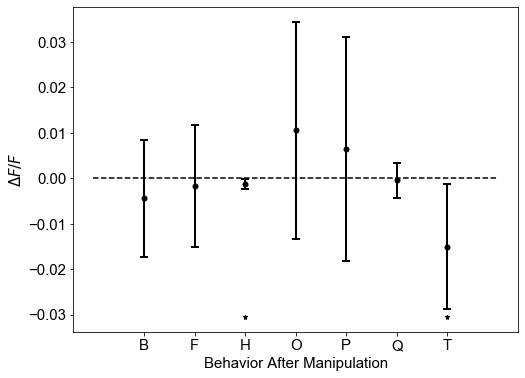

In [15]:
visualize_coefficient_stats(var_strs=after_behs, theta=after_betas, c_ints=after_c_ints, sig=after_sig,
                            x_axis_rot=0)
plt.ylabel('$\Delta F / F$')
plt.xlabel('Behavior After Manipulation')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)